In [1]:
import os
import math
import re
import json

import random

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import pandas as pd

import nltk
from nltk.stem import WordNetLemmatizer

# from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

c:\users\yasht\fakenews\venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
%matplotlib inline
random.seed(1)
np.random.seed(1)

In [3]:
w2v_model_file = 'imdb_review_w2v.model' # change each time
d2vdm_model_file = 'imdb_review_d2vdm.model' # change each time
d2vdbow_model_file = 'imdb_review_d2vdbow.model' # change each time
train_csv = 'train_df.csv'
test_csv = 'test_df.csv'
df_csv = 'df.csv'
df_pkl = 'df.pkl'

neg_bound = 4
pos_bound = 7

train_size = 0.80

num_reviews = 10000
doc_ids = range(num_reviews)

min_occ = 5 # The minimum number of occurrences for a word to be considered

In [4]:
def my_train_test_split(*args):
    return train_test_split(*args, train_size=train_size, random_state=1)

In [5]:
def get_w2v_vector(word):
    """Get the vector for a word"""
    try:
        return model.wv[word]
    except:
        print(word)
        raise
        
def filter_tokens(tokens, vocab=None):
    if vocab is None:
        vocab = w2v_vocab
    return [token for token in tokens if token in vocab]

In [6]:
en_stop = set(nltk.corpus.stopwords.words('english'))
stemmer = WordNetLemmatizer()

def tokenize(text):
    text = text.lower()
    # Remove non-word characters
    text = re.sub(r'[^a-z]', ' ', text)
    # Remove single letters
    text = re.sub(r'\b[a-z]{0,3}\b', ' ', text)
    # Merge multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Lemmatization
    tokens = text.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    
    return tokens

# Run once

In [7]:
half_reviews = num_reviews // 2
assert half_reviews == num_reviews / 2

def load_train_or_test(dir):
    random.seed(3)
    """
    Return the negative and positive train or test data
    """
    def load_neg_or_pos(sub, is_pos):
        res = []
        for file_name in os.listdir(sub):
            with open(sub + file_name, encoding='utf8') as file:
                underscore_ind = file_name.index('_')
                period_ind = file_name.index('.')
                id = int(file_name[:underscore_ind])
                rating = int(file_name[underscore_ind + 1:period_ind])
                text = next(file)
                res.append([rating, text])
        return res
    # Only choose more polar ratings
    neg = [[rating, text] for rating, text in load_neg_or_pos(dir + '/neg/', False) if rating <= neg_bound]
    pos = [[rating, text] for rating, text in load_neg_or_pos(dir + '/pos/', True) if rating >= pos_bound]
    random.shuffle(neg)
    random.shuffle(pos)
    both = neg[:half_reviews] + pos[:half_reviews]
    random.shuffle(both)
    return pd.DataFrame(both, columns=['Rating', 'Text'])

In [8]:
df = load_train_or_test('./train') #.append(load_train_or_test('./test'))

In [9]:
df

Rating                                               Text
0         10  this may not be War & Peace, but the two Acade...
1         10  after seeing this film for the 3rd time now i ...
2          1  When 'My Deja Vu, My Deja Vu' aired last seaso...
3         10  "Magic" isn't too strong a word for the spell ...
4         10  You could stage a version of Charles Dickens' ...
...      ...                                                ...
9995       8  Judy Davis shows us here why she is one of Aus...
9996       2  Don't get me wrong, I love action and revenge ...
9997       8  Im a huge M Lillard fan that's why I ended up ...
9998       8  In Iran women are prohibited from attending li...
9999       4  The movie had a cute opening, I truly believed...

[10000 rows x 2 columns]

In [10]:
df['Tokens'] = df['Text'].apply(tokenize)
# Clean up the text too
df['Text'] = df['Tokens'].apply(" ".join)

In [11]:
df

Rating                                               Text  \
0         10  peace academy noms forthcoming genius james wo...   
1         10  seeing film time think almost adam worst film ...   
2          1  deja deja aired last season pleased scrub thou...   
3         10  magic strong word spell film weave find relaxi...   
4         10  could stage version charles dickens christmas ...   
...      ...                                                ...   
9995       8  judy davis show australia respected loved acto...   
9996       2  wrong love action revenge flick seen many sinc...   
9997       8  huge lillard ended watching movie honestly dou...   
9998       8  iran woman prohibited attending live sporting ...   
9999       4  movie cute opening truly believed best romanti...   

                                                 Tokens  
0     [peace, academy, noms, forthcoming, genius, ja...  
1     [seeing, film, time, think, almost, adam, wors...  
2     [deja, deja, aired, last, season, pleased, scr...  
3     [magic, strong, word, spell, film, weave, find...  
4     [could, stage, version, charles, dickens, chri...  
...                                                 ...  
9995  [judy, davis, show, australia, respected, love...  
9996  [wrong, love, action, revenge, flick, seen, ma...  
9997  [huge, lillard, ended, watching, movie, honest...  
9998  [iran, woman, prohibited, attending, live, spo...  
9999  [movie, cute, opening, truly, believed, best, ...  

[10000 rows x 3 columns]

In [12]:
# Save processed data
# df.to_csv(df_csv)
df.to_pickle(df_pkl)

In [181]:
# # Train and save model
# model = Word2Vec(sentences=train_df['Tokens'])
# model.save(w2v_model_file)

In [182]:
# w2v_vocab = set(model.wv.key_to_index.keys())
# w2v_vocab_ord = np.array(list(model.wv.key_to_index.keys()))

In [183]:
# # Keep only tokens that showed up the required number of times
# train_df['Tokens'] = train_df['Tokens'].apply(filter_tokens)

# test_df['Tokens'] = test_df['Text'].apply(lambda text: filter_tokens(tokenize(text)))
# # Process test text too
# test_df['Text'] = test_df['Tokens'].apply(" ".join)

In [184]:
# # The vectors corresponding to each reviews' words
# df['Vectors'] = df['Tokens'].apply(get_vector)

In [13]:
# Train Doc2Vec model
import collections
from gensim.models.callbacks import CallbackAny2Vec

tagged_docs = [TaggedDocument(words=df['Tokens'][doc_id], tags=[doc_id]) for doc_id in doc_ids]
assert type(tagged_docs[0].words) == list
# print(len(tagged_docs), type(tagged_docs[0].words), tagged_docs[0])
X_train_docs, X_test_docs = my_train_test_split(tagged_docs)

class PrintLoss(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
    
    def on_epoch_begin(self, model):
        model.running_training_loss = 0.0
        print(f'Starting epoch {self.epoch}', end=' | ')
    
    def on_epoch_end(self, model):
        print(f'Finished epoch {self.epoch}, loss = {model.get_latest_training_loss()}')
        self.epoch += 1

def train_d2v(model):
    model.random.seed(1)
    model.build_vocab(X_train_docs)
    model.train(X_train_docs, total_examples=model.corpus_count, epochs=model.epochs, compute_loss=True, callbacks=[PrintLoss()])
    return model

d2vdm_model = train_d2v(Doc2Vec(dm=1, vector_size=50, min_count=min_occ, epochs=100, seed=1))
d2vdm_model.save(d2vdm_model_file)
print('Trained d2vdm')

d2vdbow_model = train_d2v(Doc2Vec(dm=0, vector_size=50, min_count=min_occ, epochs=100, seed=1))
d2vdbow_model.save(d2vdbow_model_file)
print('Trained d2vdbow')

Starting epoch 0 | Finished epoch 0, loss = 0.0
Starting epoch 1 | Finished epoch 1, loss = 0.0
Starting epoch 2 | Finished epoch 2, loss = 0.0
Starting epoch 3 | Finished epoch 3, loss = 0.0
Starting epoch 4 | Finished epoch 4, loss = 0.0
Starting epoch 5 | Finished epoch 5, loss = 0.0
Starting epoch 6 | Finished epoch 6, loss = 0.0
Starting epoch 7 | Finished epoch 7, loss = 0.0
Starting epoch 8 | Finished epoch 8, loss = 0.0
Starting epoch 9 | Finished epoch 9, loss = 0.0
Starting epoch 10 | Finished epoch 10, loss = 0.0
Starting epoch 11 | Finished epoch 11, loss = 0.0
Starting epoch 12 | Finished epoch 12, loss = 0.0
Starting epoch 13 | Finished epoch 13, loss = 0.0
Starting epoch 14 | Finished epoch 14, loss = 0.0
Starting epoch 15 | Finished epoch 15, loss = 0.0
Starting epoch 16 | Finished epoch 16, loss = 0.0
Starting epoch 17 | Finished epoch 17, loss = 0.0
Starting epoch 18 | Finished epoch 18, loss = 0.0
Starting epoch 19 | Finished epoch 19, loss = 0.0
Starting epoch 20 | 

In [22]:
def get_d2v_sim(model, doc1, doc2):
    """Get cos similarity of 2 docs' vectors"""
    vector1 = model.infer_vector(doc1)
    vector2 = model.infer_vector(doc2)
    return cosine_similarity([vector1], [vector2])

In [17]:
sim_reviews = df[df['Tokens'].apply(lambda x: 'bromwell' in x)]
sim_reviews

Rating                                               Text  \
55         9  bromwell high cartoon comedy time program scho...   
1298       9  bromwell high nothing short brilliant expertly...   

                                                 Tokens  
55    [bromwell, high, cartoon, comedy, time, progra...  
1298  [bromwell, high, nothing, short, brilliant, ex...

In [23]:
r1, r2 = sim_reviews.Tokens
get_d2v_sim(d2vdm_model, r1, r2)

array([[0.62547696]], dtype=float32)

In [24]:
get_d2v_sim(d2vdbow_model, r1, r2)

array([[0.44448546]], dtype=float32)

In [25]:
def test_d2v_sims(model):
    sims = []
    for doc_id in range(len(tagged_docs)):
        inferred_vector = model.infer_vector(tagged_docs[doc_id].words)
        actual_vector = model.dv[doc_id]
        sims.append(cosine_similarity([inferred_vector], [actual_vector])[0][0])
    return np.asarray(sims)

s1 = test_d2v_sims(d2vdm_model)
s2 = test_d2v_sims(d2vdbow_model)

KeyboardInterrupt: 

In [ ]:
s1.min(), s1.max(), s1.mean(), np.median(s1), s1.min(), s2.max(), s2.mean(), np.median(s2)

In [ ]:
def test_d2v(model):
    sims = []
    for doc_id in range(len(tagged_docs)):
        inferred_vector = model.infer_vector(tagged_docs[doc_id].words)
        actual_vector = model.dv[doc_id]
        sims.append(cosine_similarity([inferred_vector], [actual_vector])[0][0])
    return np.asarray(sims)

s1 = test_d2v_sims(d2vdm_model)
s2 = test_d2v_sims(d2vdbow_model)

# Load stuff done already

In [7]:
# df = pd.read_csv(df_csv)
df = pd.read_pickle(df_pkl)

In [8]:
# Load pretrained Word2Vec model
# model = Word2Vec.load(w2v_model_file)

In [9]:
# Load pretrained Doc2Vec models
d2vdm_model = Doc2Vec.load(d2vdm_model_file)
d2vdbow_model = Doc2Vec.load(d2vdbow_model_file)

# Common stuff

In [10]:
# vocab = set(model.wv.key_to_index.keys())
# vocab_ord = np.array(list(model.wv.key_to_index.keys()))

In [11]:
y_bi = df['Rating'] > 5
y_train_bi, y_test_bi = my_train_test_split(y_bi)

y_bin2 = df['Rating'] // 2
y_train_bin2, y_test_bin2 = my_train_test_split(y_bin2)

# Classifiers

In [80]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
[pos_train_inds, pos_test_inds], [neg_train_inds, neg_test_inds] = skf.split(np.zeroes(len(y_bi)), y_bi)


def split_bi(X):
    """Split into train, test but with an equal number of positive and negative samples"""
    
    y_train_bi_pos = df[]

In [81]:
# split_bi(y_bi)
# _train, _test=train_test_split(y_bi, train_size=train_size, stratify=[False, True], random_state=1)
# len(_train), sum(_train)

_train, _test = split_bi(y_bi)
_train, _test

(1, 2)

In [12]:
classifier_results = dict()

def score_classifier(classifier, X_test, y_test=y_test_bi, big_table=True):
    score = classifier.score(X_test, y_test)
    predicted = classifier.predict(X_test)
    cm = confusion_matrix(predicted, y_test)
    report = classification_report(predicted, y_test)
    
    classifier_results[str(classifier)] = (score, cm)
    
    print_results(score, cm, report, big_table)
    
def print_results(score, cm, class_report, big_table=True):
    print('Mean accuracy:', score)
    print(f"TP: {cm[0][0]}, FN: {cm[0][1]}\nFP: {cm[1][0]}, TN: {cm[1][1]}")
    if big_table:
        print(class_report)

In [13]:
def try_classifier(classifier, X_train, X_test, big_table=True):
    classifier.fit(X_train, y_train_bi)
    score_classifier(classifier, X_test, big_table=big_table)

def try_tfidf_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_tfidf, X_test_tfidf, big_table=big_table)

def try_d2vdm_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_d2vdm, X_test_d2vdm, big_table=big_table)
    
def try_d2vdbow_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_d2vdbow, X_test_d2vdbow, big_table=big_table)

In [14]:
# Make different train-test splits for tf-idf
def make_tfidf(**kwargs):
    # en_stop because the default apparently has problems
    tfidf_vectorizer = TfidfVectorizer(stop_words=en_stop, min_df=min_occ, **kwargs)
    X_tfidf = tfidf_vectorizer.fit_transform(df['Text'])
    X_train_tfidf, X_test_tfidf = my_train_test_split(X_tfidf)
    
    print(X_train_tfidf.shape, len(tfidf_vectorizer.vocabulary_.keys()))
    
    return X_train_tfidf, X_test_tfidf

X_train_tfidf_1, X_test_tfidf_1 = make_tfidf(ngram_range=(1, 1))
X_train_tfidf_1_2, X_test_tfidf_1_2 = make_tfidf(ngram_range=(1, 2))
X_train_tfidf_2, X_test_tfidf_2 = make_tfidf(ngram_range=(2, 2))

# The "best" tf-idf model
X_train_tfidf = X_train_tfidf_1_2

(8000, 14577) 14577
(8000, 33867) 33867
(8000, 19290) 19290


In [15]:
# Make different train-test splits for Doc2Vec
def split_d2v(model):
    train_ids, test_ids = my_train_test_split(doc_ids)
    X_train = model.dv[train_ids]
    X_test = model.dv[test_ids]
    return X_train, X_test

X_train_d2vdm, X_test_d2vdm = split_d2v(d2vdm_model)
X_train_d2vdbow, X_test_d2vdbow = split_d2v(d2vdbow_model)

In [48]:
from sklearn.manifold import TSNE

sentiment_cmap = matplotlib.colors.ListedColormap(['red', 'blue'])

def try_d2v_tsne(X_tsne, size_2d=(15, 15)):
#     cm = plt.cm.get_cmap('gist_rainbow')
    font_size = 'x-large'
    
    transposed = X_tsne.transpose()
    xs, ys = transposed
    
    fig = plt.figure(figsize=size_2d)
    ax = plt.axes()
    # Plot each word, with the third feature being 
    plot = plt.scatter(xs, ys, c=y_train_bi, cmap=sentiment_cmap)
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
#     ax.set_xlim(xlim[0], xlim[1])
#     ax.set_ylim(ylim[0], ylim[1])

    plt.show()
    
from sklearn.manifold import TSNE

def try_d2v_tsne_3d(X_tsne, size_3d=(15, 15), xlim=(-150, 300), ylim=(-600, 250), zlim=(-150, 300)):
    font_size = 'x-large'
    
    transposed = X_tsne.transpose()
    xs, ys, zs = transposed
    neg_xs = []
    neg_ys = []
    neg_zs = []
    pos_xs = []
    pos_ys = []
    pos_zs = []
    
    for x, y, z, res in zip(xs, ys, zs, y_train_bi):
        _xs, _ys, _zs = [pos_xs, pos_ys, pos_zs] if res else [neg_xs, neg_ys, neg_zs]
        _xs.append(x)
        _ys.append(y)
        _zs.append(z)
    
    fig = plt.figure(figsize=size_3d)
    ax = plt.axes(projection='3d')
    # Red is for negative reviews, blue is for positive ones
    plot = ax.scatter(xs, ys, zs, c=y_train_bi, cmap=sentiment_cmap)
    
#     plt.colorbar(plot)

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])

    plt.show()
    
    # Just plot negative reviews
    fig = plt.figure(figsize=size_3d)
    ax = plt.axes(projection='3d')
    plot = ax.scatter(neg_xs, neg_ys, neg_zs, c='red')
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])

    plt.show()
    
    # Just plot positive reviews
    fig = plt.figure(figsize=size_3d)
    ax = plt.axes(projection='3d')
    plot = ax.scatter(pos_xs, pos_ys, pos_zs, c='blue')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])

    plt.show()

In [36]:
X_tsne_d2vdm2d = TSNE(n_components=2).fit_transform(X_train_d2vdm)

In [37]:
X_tsne_d2vdm3d = TSNE(n_components=3).fit_transform(X_train_d2vdm)

In [38]:
X_tsne_d2vdbow2d = TSNE(n_components=2).fit_transform(X_train_d2vdbow)

In [39]:
X_tsne_d2vdbow3d = TSNE(n_components=3).fit_transform(X_train_d2vdbow)

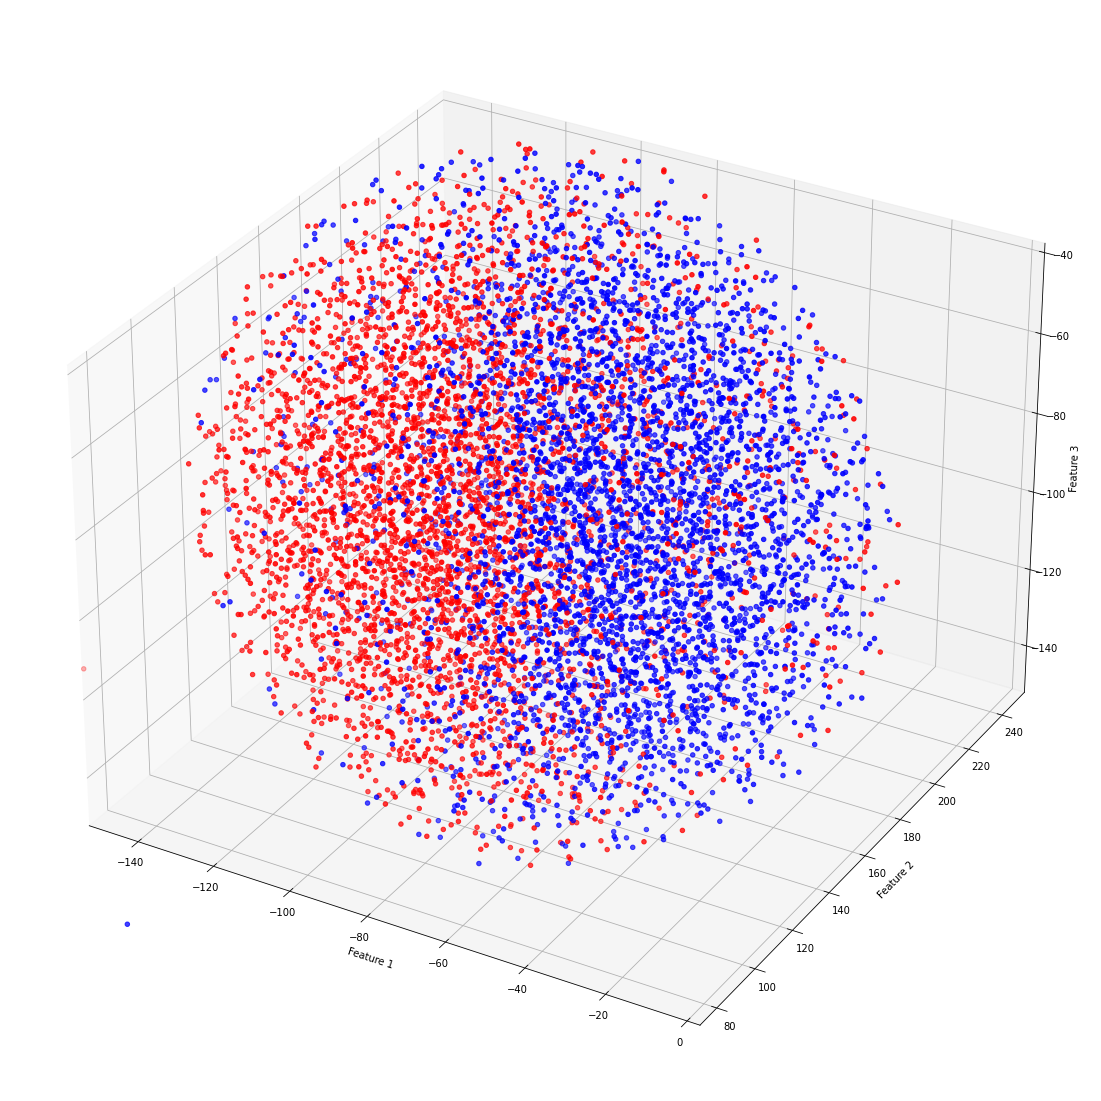

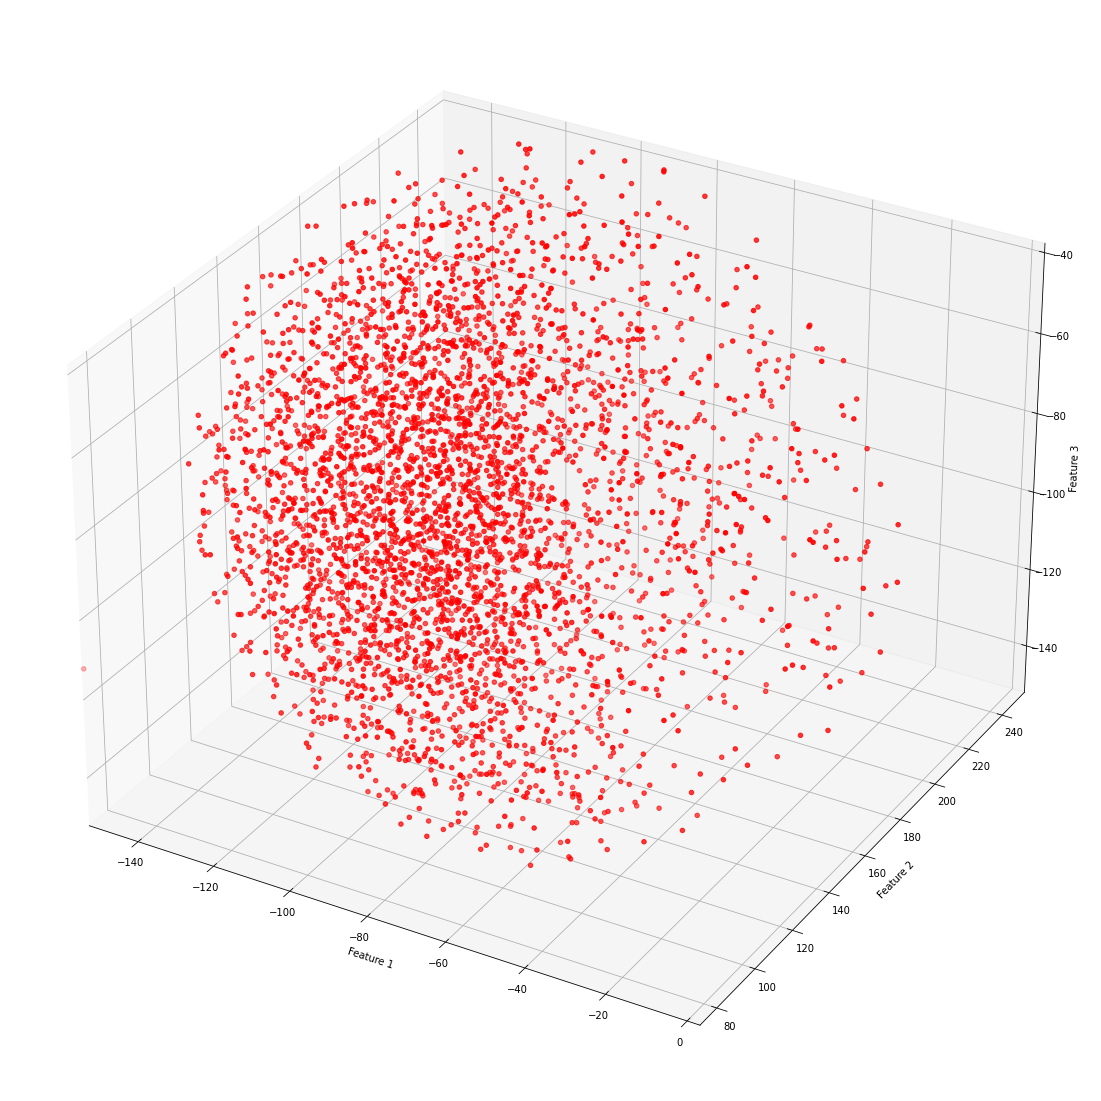

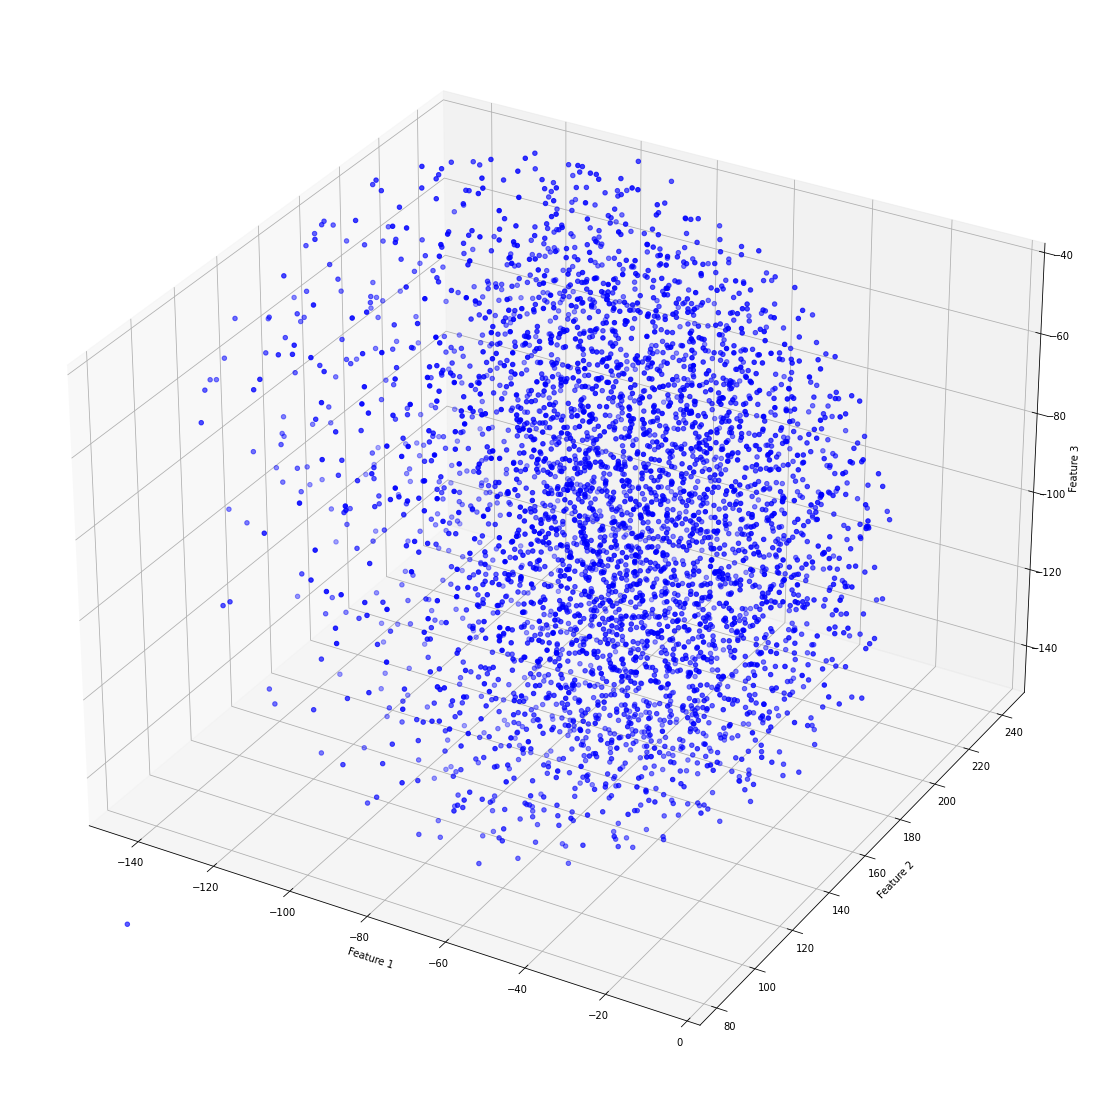

In [50]:
# Current boundaries miss outliers!
try_d2v_tsne_3d(X_tsne_d2vdm3d, xlim=(-150, 0), ylim=(75, 250), zlim=(-150, -40), size_3d=(20, 20))

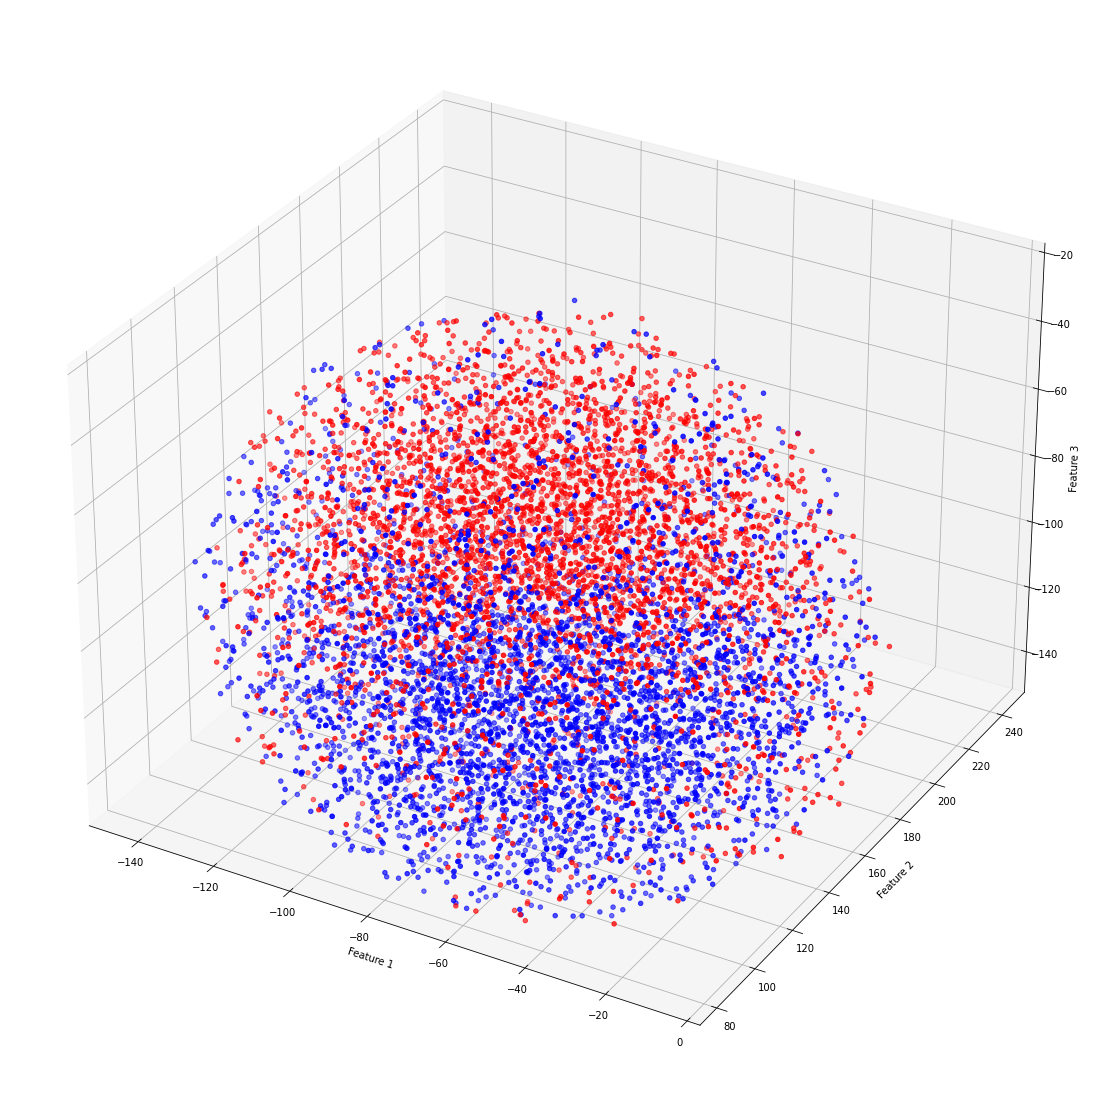

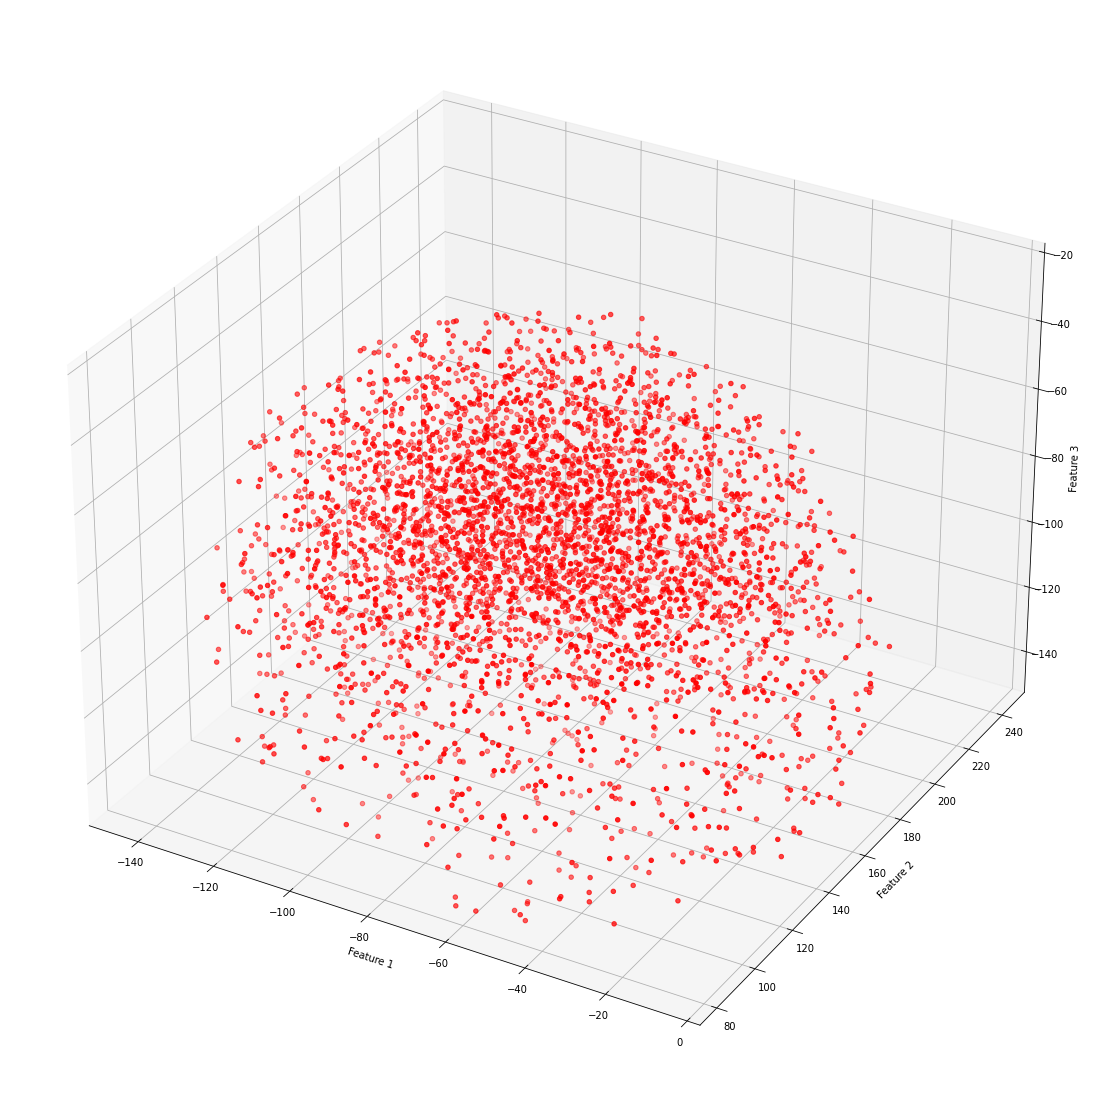

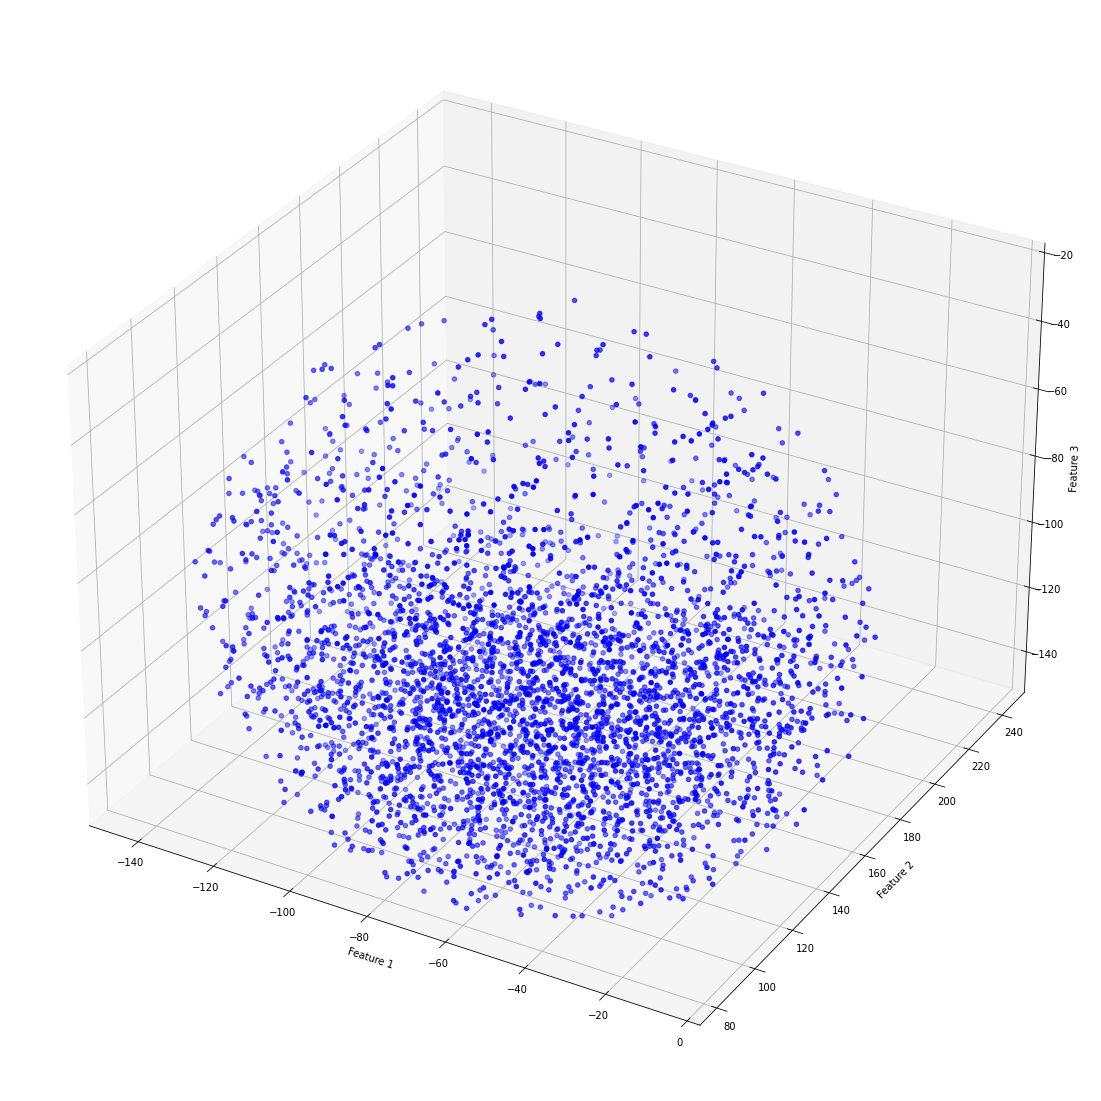

In [53]:
# Current boundaries miss outliers!
try_d2v_tsne_3d(X_tsne_d2vdbow3d, xlim=(-150, 0), ylim=(75, 250), zlim=(-150, -20), size_3d=(20, 20))

# Logistic Regression + Bag of Words

In [34]:
def try_bow(**kwargs):
    cnt_vectorizer = CountVectorizer(stop_words=en_stop, **kwargs) # en_stop because the default has problems
    X_bow = cnt_vectorizer.fit_transform(df['Text'])
    X_train_bow, X_test_bow = train_test_split(X_bow, train_size=train_size, random_state=1)

    # Scale data
    scaler_bow = StandardScaler(with_mean=False).fit(X_train_bow)
    X_train_bow_scaled = scaler_bow.transform(X_train_bow)
    X_test_bow_scaled = scaler_bow.transform(X_test_bow)
    print(X_train_bow_scaled.shape, len(cnt_vectorizer.vocabulary_.keys()))
    
    lr_bow = LogisticRegression()
    lr_bow.fit(X_train_bow_scaled, y_train_bi)
    
    score_classifier(lr_bow, X_test_bow_scaled)

In [35]:
try_bow(min_df=5, ngram_range=(1, 1)) # Just unigrams

(8000, 14577) 14577
Mean accuracy: 0.83
TP: 823, FN: 146
FP: 194, TN: 837
              precision    recall  f1-score   support

       False       0.81      0.85      0.83       969
        True       0.85      0.81      0.83      1031

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [36]:
try_bow(min_df=5, ngram_range=(1, 2)) # Unigrams and bigrams

(8000, 33867) 33867
Mean accuracy: 0.8435
TP: 842, FN: 138
FP: 175, TN: 845
              precision    recall  f1-score   support

       False       0.83      0.86      0.84       980
        True       0.86      0.83      0.84      1020

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [37]:
try_bow(min_df=5, ngram_range=(2, 2)) # Just bigrams

(8000, 19290) 19290
Mean accuracy: 0.75
TP: 748, FN: 231
FP: 269, TN: 752
              precision    recall  f1-score   support

       False       0.74      0.76      0.75       979
        True       0.77      0.74      0.75      1021

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



In [38]:
try_bow(min_df=5, ngram_range=(1, 3)) # Unigrams, bigrams, and trigrams

(8000, 34908) 34908
Mean accuracy: 0.843
TP: 840, FN: 137
FP: 177, TN: 846
              precision    recall  f1-score   support

       False       0.83      0.86      0.84       977
        True       0.86      0.83      0.84      1023

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



# Logistic Regression + TFIDF

In [39]:
def try_tfidf(X_train_tfidf, X_test_tfidf):    
    lr_tfidf = LogisticRegression()
    lr_tfidf.fit(X_train_tfidf, y_train_bi)
    
    score_classifier(lr_tfidf, X_test_tfidf)

In [40]:
X_train_tfidf_1, X_test_tfidf_1 = make_tfidf(ngram_range=(1, 1))
X_train_tfidf_1_2, X_test_tfidf_1_2 = make_tfidf(ngram_range=(1, 2))
X_train_tfidf_2, X_test_tfidf_2 = make_tfidf(ngram_range=(2, 2))

(8000, 14577) 14577
(8000, 33867) 33867
(8000, 19290) 19290


In [41]:
try_tfidf(X_train_tfidf_1, X_test_tfidf_1)

Mean accuracy: 0.865
TP: 848, FN: 101
FP: 169, TN: 882
              precision    recall  f1-score   support

       False       0.83      0.89      0.86       949
        True       0.90      0.84      0.87      1051

    accuracy                           0.86      2000
   macro avg       0.87      0.87      0.86      2000
weighted avg       0.87      0.86      0.87      2000



In [42]:
try_tfidf(X_train_tfidf_1_2, X_test_tfidf_1_2)

Mean accuracy: 0.8655
TP: 845, FN: 97
FP: 172, TN: 886
              precision    recall  f1-score   support

       False       0.83      0.90      0.86       942
        True       0.90      0.84      0.87      1058

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



In [43]:
try_tfidf(X_train_tfidf_2, X_test_tfidf_2)

Mean accuracy: 0.8035
TP: 779, FN: 155
FP: 238, TN: 828
              precision    recall  f1-score   support

       False       0.77      0.83      0.80       934
        True       0.84      0.78      0.81      1066

    accuracy                           0.80      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.81      0.80      0.80      2000



In [44]:
# Choose the best tf-idf model
X_train_tfidf = X_train_tfidf_1_2
X_test_tfidf = X_test_tfidf_1_2

# Logistic Regression + Doc2Vec (DM)

In [54]:
score_classifier(LogisticRegression().fit(X_train_d2vdm, y_train_bi), X_test_d2vdm)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression + Doc2Vec (DBOW)

In [57]:
sum(y_train_bi == 1), len(y_train_bi)

(4017, 8000)

In [46]:
score_classifier(LogisticRegression().fit(X_train_d2vdbow, y_train_bi), X_test_d2vdbow)

Mean accuracy: 0.508
TP: 1013, FN: 980
FP: 4, TN: 3
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      1993
        True       0.00      0.43      0.01         7

    accuracy                           0.51      2000
   macro avg       0.50      0.47      0.34      2000
weighted avg       0.99      0.51      0.67      2000



# Random forests + tf-idf

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
try_tfidf_classifier(RandomForestClassifier(max_depth=2, random_state=1))

Mean accuracy: 0.75
TP: 634, FN: 117
FP: 383, TN: 866
              precision    recall  f1-score   support

       False       0.62      0.84      0.72       751
        True       0.88      0.69      0.78      1249

    accuracy                           0.75      2000
   macro avg       0.75      0.77      0.75      2000
weighted avg       0.78      0.75      0.75      2000



In [49]:
try_tfidf_classifier(RandomForestClassifier(max_depth=3, random_state=1))

Mean accuracy: 0.78
TP: 688, FN: 111
FP: 329, TN: 872
              precision    recall  f1-score   support

       False       0.68      0.86      0.76       799
        True       0.89      0.73      0.80      1201

    accuracy                           0.78      2000
   macro avg       0.78      0.79      0.78      2000
weighted avg       0.80      0.78      0.78      2000



In [50]:
try_tfidf_classifier(RandomForestClassifier(max_depth=5, random_state=1))

Mean accuracy: 0.79
TP: 707, FN: 110
FP: 310, TN: 873
              precision    recall  f1-score   support

       False       0.70      0.87      0.77       817
        True       0.89      0.74      0.81      1183

    accuracy                           0.79      2000
   macro avg       0.79      0.80      0.79      2000
weighted avg       0.81      0.79      0.79      2000



In [51]:
try_tfidf_classifier(RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1))

Mean accuracy: 0.7955
TP: 704, FN: 96
FP: 313, TN: 887
              precision    recall  f1-score   support

       False       0.69      0.88      0.77       800
        True       0.90      0.74      0.81      1200

    accuracy                           0.80      2000
   macro avg       0.80      0.81      0.79      2000
weighted avg       0.82      0.80      0.80      2000



In [52]:
try_tfidf_classifier(RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200, random_state=1))

Mean accuracy: 0.8085
TP: 738, FN: 104
FP: 279, TN: 879
              precision    recall  f1-score   support

       False       0.73      0.88      0.79       842
        True       0.89      0.76      0.82      1158

    accuracy                           0.81      2000
   macro avg       0.81      0.82      0.81      2000
weighted avg       0.82      0.81      0.81      2000



In [53]:
try_tfidf_classifier(RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200, random_state=1))

Mean accuracy: 0.811
TP: 760, FN: 121
FP: 257, TN: 862
              precision    recall  f1-score   support

       False       0.75      0.86      0.80       881
        True       0.88      0.77      0.82      1119

    accuracy                           0.81      2000
   macro avg       0.81      0.82      0.81      2000
weighted avg       0.82      0.81      0.81      2000



In [54]:
try_tfidf_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300, random_state=1))

Mean accuracy: 0.824
TP: 775, FN: 110
FP: 242, TN: 873
              precision    recall  f1-score   support

       False       0.76      0.88      0.81       885
        True       0.89      0.78      0.83      1115

    accuracy                           0.82      2000
   macro avg       0.83      0.83      0.82      2000
weighted avg       0.83      0.82      0.82      2000



In [55]:
try_tfidf_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300, random_state=2))

Mean accuracy: 0.825
TP: 777, FN: 110
FP: 240, TN: 873
              precision    recall  f1-score   support

       False       0.76      0.88      0.82       887
        True       0.89      0.78      0.83      1113

    accuracy                           0.82      2000
   macro avg       0.83      0.83      0.82      2000
weighted avg       0.83      0.82      0.83      2000



In [56]:
try_tfidf_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300, random_state=2))

Mean accuracy: 0.825
TP: 774, FN: 107
FP: 243, TN: 876
              precision    recall  f1-score   support

       False       0.76      0.88      0.82       881
        True       0.89      0.78      0.83      1119

    accuracy                           0.82      2000
   macro avg       0.83      0.83      0.82      2000
weighted avg       0.83      0.82      0.83      2000



In [57]:
try_tfidf_classifier(RandomForestClassifier(max_depth=16, n_estimators=400, random_state=2), big_table=False)

Mean accuracy: 0.829
TP: 796, FN: 121
FP: 221, TN: 862


In [58]:
try_tfidf_classifier(RandomForestClassifier(max_depth=20, n_estimators=600, random_state=1), big_table=False)

Mean accuracy: 0.8385
TP: 812, FN: 118
FP: 205, TN: 865


In [59]:
try_tfidf_classifier(RandomForestClassifier(max_depth=20, n_estimators=800, random_state=1), big_table=False)

Mean accuracy: 0.8395
TP: 811, FN: 115
FP: 206, TN: 868


# Random Forest + Doc2Vec (DM)

In [60]:
try_classifier(, X_train_tfidf, X_test_tfidfRandomForestClassifier(max_depth=2, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.4915
TP: 0, FN: 0
FP: 1017, TN: 983
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.49      0.66      2000

    accuracy                           0.49      2000
   macro avg       0.50      0.25      0.33      2000
weighted avg       1.00      0.49      0.66      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
try_classifier(RandomForestClassifier(max_depth=3, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.503
TP: 942, FN: 919
FP: 75, TN: 64
              precision    recall  f1-score   support

       False       0.93      0.51      0.65      1861
        True       0.07      0.46      0.11       139

    accuracy                           0.50      2000
   macro avg       0.50      0.48      0.38      2000
weighted avg       0.87      0.50      0.62      2000



In [62]:
try_classifier(RandomForestClassifier(max_depth=5, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
try_classifier(RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.4915
TP: 0, FN: 0
FP: 1017, TN: 983
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.49      0.66      2000

    accuracy                           0.49      2000
   macro avg       0.50      0.25      0.33      2000
weighted avg       1.00      0.49      0.66      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
try_classifier(RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.514
TP: 543, FN: 498
FP: 474, TN: 485
              precision    recall  f1-score   support

       False       0.53      0.52      0.53      1041
        True       0.49      0.51      0.50       959

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [65]:
try_classifier(RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.4915
TP: 0, FN: 0
FP: 1017, TN: 983
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.49      0.66      2000

    accuracy                           0.49      2000
   macro avg       0.50      0.25      0.33      2000
weighted avg       1.00      0.49      0.66      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
try_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
try_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300, random_state=2), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.508
TP: 1016, FN: 983
FP: 1, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      1999
        True       0.00      0.00      0.00         1

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



In [68]:
try_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300, random_state=2), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.4915
TP: 0, FN: 0
FP: 1017, TN: 983
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.49      0.66      2000

    accuracy                           0.49      2000
   macro avg       0.50      0.25      0.33      2000
weighted avg       1.00      0.49      0.66      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
try_classifier(RandomForestClassifier(max_depth=16, n_estimators=400, random_state=2), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.508
TP: 1006, FN: 973
FP: 11, TN: 10
              precision    recall  f1-score   support

       False       0.99      0.51      0.67      1979
        True       0.01      0.48      0.02        21

    accuracy                           0.51      2000
   macro avg       0.50      0.49      0.35      2000
weighted avg       0.98      0.51      0.66      2000



In [70]:
try_classifier(RandomForestClassifier(max_depth=20, n_estimators=600, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.4915
TP: 0, FN: 0
FP: 1017, TN: 983
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.49      0.66      2000

    accuracy                           0.49      2000
   macro avg       0.50      0.25      0.33      2000
weighted avg       1.00      0.49      0.66      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
try_classifier(RandomForestClassifier(max_depth=20, n_estimators=800, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.4915
TP: 0, FN: 0
FP: 1017, TN: 983
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.49      0.66      2000

    accuracy                           0.49      2000
   macro avg       0.50      0.25      0.33      2000
weighted avg       1.00      0.49      0.66      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest + Doc2Vec (DBOW)

In [99]:
try_classifier(RandomForestClassifier(max_depth=2, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
try_classifier(RandomForestClassifier(max_depth=3, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
try_classifier(RandomForestClassifier(max_depth=5, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
try_classifier(RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [103]:
try_classifier(RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
try_classifier(RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
try_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
try_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300, random_state=2), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.509
TP: 1016, FN: 981
FP: 1, TN: 2
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      1997
        True       0.00      0.67      0.00         3

    accuracy                           0.51      2000
   macro avg       0.50      0.59      0.34      2000
weighted avg       1.00      0.51      0.67      2000



In [107]:
try_classifier(RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300, random_state=2), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5075
TP: 996, FN: 964
FP: 21, TN: 19
              precision    recall  f1-score   support

       False       0.98      0.51      0.67      1960
        True       0.02      0.47      0.04        40

    accuracy                           0.51      2000
   macro avg       0.50      0.49      0.35      2000
weighted avg       0.96      0.51      0.66      2000



In [108]:
try_classifier(RandomForestClassifier(max_depth=16, n_estimators=400, random_state=2), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
try_classifier(RandomForestClassifier(max_depth=20, n_estimators=600, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
try_classifier(RandomForestClassifier(max_depth=20, n_estimators=800, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM + tf-idf

In [94]:
try_classifier(SVC(kernel='linear', random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.8675
TP: 855, FN: 103
FP: 162, TN: 880
              precision    recall  f1-score   support

       False       0.84      0.89      0.87       958
        True       0.90      0.84      0.87      1042

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



In [95]:
try_classifier(SVC(kernel='rbf', random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.874
TP: 851, FN: 86
FP: 166, TN: 897
              precision    recall  f1-score   support

       False       0.84      0.91      0.87       937
        True       0.91      0.84      0.88      1063

    accuracy                           0.87      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.88      0.87      0.87      2000



In [96]:
try_classifier(SVC(kernel='poly', degree=2, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.8595
TP: 831, FN: 95
FP: 186, TN: 888
              precision    recall  f1-score   support

       False       0.82      0.90      0.86       926
        True       0.90      0.83      0.86      1074

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [97]:
try_classifier(SVC(kernel='poly', degree=3, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.824
TP: 833, FN: 168
FP: 184, TN: 815
              precision    recall  f1-score   support

       False       0.82      0.83      0.83      1001
        True       0.83      0.82      0.82       999

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [98]:
try_classifier(SVC(kernel='sigmoid', random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.868
TP: 854, FN: 101
FP: 163, TN: 882
              precision    recall  f1-score   support

       False       0.84      0.89      0.87       955
        True       0.90      0.84      0.87      1045

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



In [73]:
try_classifier(SVC(kernel='linear', max_iter=1000, random_state=1), X_train_tfidf, X_test_tfidf)

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.8405
TP: 829, FN: 131
FP: 188, TN: 852
              precision    recall  f1-score   support

       False       0.82      0.86      0.84       960
        True       0.87      0.82      0.84      1040

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [75]:
try_classifier(SVC(kernel='rbf', max_iter=1000, random_state=1), X_train_tfidf, X_test_tfidf)

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.84
TP: 821, FN: 124
FP: 196, TN: 859
              precision    recall  f1-score   support

       False       0.81      0.87      0.84       945
        True       0.87      0.81      0.84      1055

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [76]:
try_classifier(SVC(kernel='poly', degree=2, max_iter=1000, random_state=1), X_train_tfidf, X_test_tfidf)

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.8225
TP: 809, FN: 147
FP: 208, TN: 836
              precision    recall  f1-score   support

       False       0.80      0.85      0.82       956
        True       0.85      0.80      0.82      1044

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [77]:
try_classifier(SVC(kernel='poly', degree=3, max_iter=1000, random_state=1), X_train_tfidf, X_test_tfidf)

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.7385
TP: 601, FN: 107
FP: 416, TN: 876
              precision    recall  f1-score   support

       False       0.59      0.85      0.70       708
        True       0.89      0.68      0.77      1292

    accuracy                           0.74      2000
   macro avg       0.74      0.76      0.73      2000
weighted avg       0.78      0.74      0.74      2000



In [78]:
try_classifier(SVC(kernel='poly', degree=4, max_iter=1000, random_state=1), X_train_tfidf, X_test_tfidf)

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.592
TP: 283, FN: 82
FP: 734, TN: 901
              precision    recall  f1-score   support

       False       0.28      0.78      0.41       365
        True       0.92      0.55      0.69      1635

    accuracy                           0.59      2000
   macro avg       0.60      0.66      0.55      2000
weighted avg       0.80      0.59      0.64      2000



In [79]:
try_classifier(SVC(kernel='sigmoid', max_iter=1000, random_state=1), X_train_tfidf, X_test_tfidf)

c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.8375
TP: 848, FN: 156
FP: 169, TN: 827
              precision    recall  f1-score   support

       False       0.83      0.84      0.84      1004
        True       0.84      0.83      0.84       996

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



# SVM + Doc2Vec (DM)

In [127]:
try_classifier(SVC(kernel='linear', max_iter=-1, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
try_classifier(SVC(kernel='rbf', max_iter=-1, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
try_classifier(SVC(kernel='poly', degree=2, max_iter=-1, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
try_classifier(SVC(kernel='poly', degree=3, max_iter=-1, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
try_classifier(SVC(kernel='poly', degree=4, max_iter=-1, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [121]:
try_classifier(SVC(kernel='sigmoid', max_iter=-1, random_state=1), X_train_d2vdm, X_test_d2vdm)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM + Doc2Vec (DBOW)

In [130]:
try_classifier(SVC(kernel='linear', max_iter=-1, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
try_classifier(SVC(kernel='rbf', max_iter=-1, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
try_classifier(SVC(kernel='poly', degree=2, max_iter=-1, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [133]:
try_classifier(SVC(kernel='poly', degree=3, max_iter=-1, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
try_classifier(SVC(kernel='poly', degree=4, max_iter=-1, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
try_classifier(SVC(kernel='sigmoid', max_iter=-1, random_state=1), X_train_d2vdbow, X_test_d2vdbow)

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Extra Trees + tf-idf

In [80]:
from sklearn.ensemble import ExtraTreesClassifier

In [81]:
try_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=100, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.7625
TP: 636, FN: 94
FP: 381, TN: 889
              precision    recall  f1-score   support

       False       0.63      0.87      0.73       730
        True       0.90      0.70      0.79      1270

    accuracy                           0.76      2000
   macro avg       0.76      0.79      0.76      2000
weighted avg       0.80      0.76      0.77      2000



In [82]:
try_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=100, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.8035
TP: 720, FN: 96
FP: 297, TN: 887
              precision    recall  f1-score   support

       False       0.71      0.88      0.79       816
        True       0.90      0.75      0.82      1184

    accuracy                           0.80      2000
   macro avg       0.81      0.82      0.80      2000
weighted avg       0.82      0.80      0.81      2000



In [83]:
try_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=100, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.8095
TP: 752, FN: 116
FP: 265, TN: 867
              precision    recall  f1-score   support

       False       0.74      0.87      0.80       868
        True       0.88      0.77      0.82      1132

    accuracy                           0.81      2000
   macro avg       0.81      0.82      0.81      2000
weighted avg       0.82      0.81      0.81      2000



In [84]:
try_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.7865
TP: 670, FN: 80
FP: 347, TN: 903
              precision    recall  f1-score   support

       False       0.66      0.89      0.76       750
        True       0.92      0.72      0.81      1250

    accuracy                           0.79      2000
   macro avg       0.79      0.81      0.78      2000
weighted avg       0.82      0.79      0.79      2000



In [85]:
try_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.814
TP: 708, FN: 63
FP: 309, TN: 920
              precision    recall  f1-score   support

       False       0.70      0.92      0.79       771
        True       0.94      0.75      0.83      1229

    accuracy                           0.81      2000
   macro avg       0.82      0.83      0.81      2000
weighted avg       0.84      0.81      0.82      2000



In [86]:
try_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.8195
TP: 737, FN: 81
FP: 280, TN: 902
              precision    recall  f1-score   support

       False       0.72      0.90      0.80       818
        True       0.92      0.76      0.83      1182

    accuracy                           0.82      2000
   macro avg       0.82      0.83      0.82      2000
weighted avg       0.84      0.82      0.82      2000



In [87]:
try_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.833
TP: 772, FN: 89
FP: 245, TN: 894
              precision    recall  f1-score   support

       False       0.76      0.90      0.82       861
        True       0.91      0.78      0.84      1139

    accuracy                           0.83      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.84      0.83      0.83      2000



In [88]:
try_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.8345
TP: 767, FN: 81
FP: 250, TN: 902
              precision    recall  f1-score   support

       False       0.75      0.90      0.82       848
        True       0.92      0.78      0.84      1152

    accuracy                           0.83      2000
   macro avg       0.84      0.84      0.83      2000
weighted avg       0.85      0.83      0.84      2000



In [89]:
try_classifier(ExtraTreesClassifier(max_depth=20, n_estimators=800, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.844
TP: 801, FN: 96
FP: 216, TN: 887
              precision    recall  f1-score   support

       False       0.79      0.89      0.84       897
        True       0.90      0.80      0.85      1103

    accuracy                           0.84      2000
   macro avg       0.84      0.85      0.84      2000
weighted avg       0.85      0.84      0.84      2000



In [90]:
try_classifier(ExtraTreesClassifier(max_depth=25, n_estimators=1000, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.8475
TP: 808, FN: 96
FP: 209, TN: 887
              precision    recall  f1-score   support

       False       0.79      0.89      0.84       904
        True       0.90      0.81      0.85      1096

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [91]:
try_classifier(ExtraTreesClassifier(max_depth=30, n_estimators=1500, random_state=1), X_train_tfidf, X_test_tfidf)

Mean accuracy: 0.8465
TP: 808, FN: 98
FP: 209, TN: 885
              precision    recall  f1-score   support

       False       0.79      0.89      0.84       906
        True       0.90      0.81      0.85      1094

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



# Extra Trees + Doc2Vec (DM)

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

In [22]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=100, random_state=1))

Mean accuracy: 0.5065
TP: 990, FN: 960
FP: 27, TN: 23
              precision    recall  f1-score   support

       False       0.97      0.51      0.67      1950
        True       0.02      0.46      0.04        50

    accuracy                           0.51      2000
   macro avg       0.50      0.48      0.36      2000
weighted avg       0.95      0.51      0.65      2000



In [23]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=100, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=100, random_state=1))

Mean accuracy: 0.8095
TP: 752, FN: 116
FP: 265, TN: 867
              precision    recall  f1-score   support

       False       0.74      0.87      0.80       868
        True       0.88      0.77      0.82      1132

    accuracy                           0.81      2000
   macro avg       0.81      0.82      0.81      2000
weighted avg       0.82      0.81      0.81      2000



In [84]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1))

Mean accuracy: 0.7865
TP: 670, FN: 80
FP: 347, TN: 903
              precision    recall  f1-score   support

       False       0.66      0.89      0.76       750
        True       0.92      0.72      0.81      1250

    accuracy                           0.79      2000
   macro avg       0.79      0.81      0.78      2000
weighted avg       0.82      0.79      0.79      2000



In [85]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1))

Mean accuracy: 0.814
TP: 708, FN: 63
FP: 309, TN: 920
              precision    recall  f1-score   support

       False       0.70      0.92      0.79       771
        True       0.94      0.75      0.83      1229

    accuracy                           0.81      2000
   macro avg       0.82      0.83      0.81      2000
weighted avg       0.84      0.81      0.82      2000



In [86]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1))

Mean accuracy: 0.8195
TP: 737, FN: 81
FP: 280, TN: 902
              precision    recall  f1-score   support

       False       0.72      0.90      0.80       818
        True       0.92      0.76      0.83      1182

    accuracy                           0.82      2000
   macro avg       0.82      0.83      0.82      2000
weighted avg       0.84      0.82      0.82      2000



In [87]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1))

Mean accuracy: 0.833
TP: 772, FN: 89
FP: 245, TN: 894
              precision    recall  f1-score   support

       False       0.76      0.90      0.82       861
        True       0.91      0.78      0.84      1139

    accuracy                           0.83      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.84      0.83      0.83      2000



In [88]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1))

Mean accuracy: 0.8345
TP: 767, FN: 81
FP: 250, TN: 902
              precision    recall  f1-score   support

       False       0.75      0.90      0.82       848
        True       0.92      0.78      0.84      1152

    accuracy                           0.83      2000
   macro avg       0.84      0.84      0.83      2000
weighted avg       0.85      0.83      0.84      2000



In [19]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=20, n_estimators=800, random_state=1))

Mean accuracy: 0.5135
TP: 972, FN: 928
FP: 45, TN: 55
              precision    recall  f1-score   support

       False       0.96      0.51      0.67      1900
        True       0.06      0.55      0.10       100

    accuracy                           0.51      2000
   macro avg       0.51      0.53      0.38      2000
weighted avg       0.91      0.51      0.64      2000



In [20]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=25, n_estimators=1000, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
try_d2vdm_classifier(ExtraTreesClassifier(max_depth=30, n_estimators=1500, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Extra Trees + Doc2Vec (DBOW)

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

In [24]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=100, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=100, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=100, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1))

Mean accuracy: 0.5035
TP: 531, FN: 507
FP: 486, TN: 476
              precision    recall  f1-score   support

       False       0.52      0.51      0.52      1038
        True       0.48      0.49      0.49       962

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [28]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1))

Mean accuracy: 0.508
TP: 980, FN: 947
FP: 37, TN: 36
              precision    recall  f1-score   support

       False       0.96      0.51      0.67      1927
        True       0.04      0.49      0.07        73

    accuracy                           0.51      2000
   macro avg       0.50      0.50      0.37      2000
weighted avg       0.93      0.51      0.64      2000



In [29]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=20, n_estimators=800, random_state=1))

Mean accuracy: 0.5095
TP: 1017, FN: 981
FP: 0, TN: 2
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      1998
        True       0.00      1.00      0.00         2

    accuracy                           0.51      2000
   macro avg       0.50      0.75      0.34      2000
weighted avg       1.00      0.51      0.67      2000



In [33]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=25, n_estimators=1000, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
try_d2vdbow_classifier(ExtraTreesClassifier(max_depth=30, n_estimators=1500, random_state=1))

Mean accuracy: 0.5085
TP: 1017, FN: 983
FP: 0, TN: 0
              precision    recall  f1-score   support

       False       1.00      0.51      0.67      2000
        True       0.00      0.00      0.00         0

    accuracy                           0.51      2000
   macro avg       0.50      0.25      0.34      2000
weighted avg       1.00      0.51      0.67      2000



c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
classifier_results

{'LogisticRegression()': (0.508,
  array([[1013,  980],
         [   4,    3]], dtype=int64)),
 'RandomForestClassifier(max_depth=2, random_state=1)': (0.4915,
  array([[   0,    0],
         [1017,  983]], dtype=int64)),
 'RandomForestClassifier(max_depth=3, random_state=1)': (0.503,
  array([[942, 919],
         [ 75,  64]], dtype=int64)),
 'RandomForestClassifier(max_depth=5, random_state=1)': (0.5085,
  array([[1017,  983],
         [   0,    0]], dtype=int64)),
 'RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1)': (0.4915,
  array([[   0,    0],
         [1017,  983]], dtype=int64)),
 'RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,\n                       random_state=1)': (0.514,
  array([[543, 498],
         [474, 485]], dtype=int64)),
 'RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200,\n                       random_state=1)': (0.4915,
  array([[   0,    0],
         [1017,  983]], dtype=int64)),
 'RandomF